## Prompts for locations

In [ ]:
location_prompts = [
    "steampunk city with skyscrapers",
    "cyberpunk village in Japanese rustic style",
    "fantasy dungsseons and dragons",
    "noir city from 1930s",
    "StarTrek inspired spaceship",
    "undeground mine of goblins",
    "SuperMario style magic land plain",
    "SuperMario style magic land beach",
]

## Generating locations 

In [ ]:
from holodeck import initialize_location
from holodeck import generate_location_and_encounters
import os
from tqdm.notebook import tqdm
import traceback

import concurrent.futures
from tqdm import tqdm

def generate_location(prompt):
    location_dict, encounters_list = generate_location_and_encounters(prompt)
    if location_dict:
        try:
            location = initialize_location(location_dict, encounters_list)
            return location
        except Exception as e:
            print("Error: ", e)
            traceback.print_exc()
    else:
        print(f"GENERATING FROM '{prompt}' failed!")
        return None

locations = []
with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    results = list(tqdm(executor.map(generate_location, location_prompts), total=len(location_prompts), desc="Generating locations"))
    locations += [r for r in results if r is not None]


assert len(locations) == len(location_prompts), "some locations are failed to generate"

locations

In [ ]:
locations[0].characters

## Save Locations to sqlite

In [ ]:
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlite3 import dbapi2 as sqlite
from sqlmodel import SQLModel
def save_locations():

    # Make sure the .data directory exists
    if not os.path.exists('.data'):
        os.mkdir('.data')

    # Remove the database file if it exists
    if os.path.exists('.data/locations.db'):
        os.remove('.data/locations.db')

    # Create the engine that connects to the SQLite database
    engine = create_engine('sqlite+pysqlite:///.data/locations.db', module=sqlite)

    # Define a session factory that will be used to interact with the database
    Session = sessionmaker(bind=engine)

    # Create the tables in the database
    SQLModel.metadata.create_all(engine)

    # Open a session and add the locations list to it
    with Session() as session:
        for location in locations:
            session.add(location)
        session.commit()

    # Close the database connection
    engine.dispose()
save_locations()

## Load Locations from sqlite

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlite3 import dbapi2 as sqlite
from holodeck import *
from sqlmodel import select
from sqlalchemy.orm import selectinload, joinedload

def get_saved_locations():
    engine = create_engine('sqlite+pysqlite:///.data/locations.db', module=sqlite)

    SessionLocal = sessionmaker(bind=engine)

    with SessionLocal() as session:
        locations = session.query(Location).options(
            joinedload(Location.buildings),
            joinedload(Location.ways),
            joinedload(Location.encounters).joinedload(Encounter.actions)
                .joinedload(Action.critter),
            joinedload(Location.encounters).joinedload(Encounter.actions)
                .joinedload(Action.character),
            joinedload(Location.encounters).joinedload(Encounter.actions)
                .joinedload(Action.item),
            joinedload(Location.encounters).joinedload(Encounter.actions)
                .joinedload(Action.building),
            joinedload(Location.encounters).joinedload(Encounter.triggers).joinedload(Trigger.way),
            joinedload(Location.encounters).joinedload(Encounter.triggers).joinedload(Trigger.building),
            joinedload(Location.characters)
        ).all()

        return [location for location in locations]

get_saved_locations()




# Remove the loaded objects from the session cache
# session.expunge_all()

# Close the database connection
# engine.dispose()

[Location(id=1, description='This spaceship is comprised of one central hub and five separate wings, each with its own capabilities. The ship is large and imposing, with a red hull and sharp angles. The docking bay, located at the front of the ship, is the only way to enter and exit.\n', name='Star Trek Inspired Spaceship', characters=[], buildings=[Building(location_id=1, id=2, description='This wing is repurposed for storing cargo and other supplies, whether acquired on mission or brought on board.', name='Cargo Wing', enterable=True), Building(location_id=1, id=1, description='This is the nucleus of the ship, holding the bridge and living quarters of the crew.', name='Central Hub', enterable=True), Building(location_id=1, id=5, description='This wing houses the equipment and control panels for managing the ship during missions.', name='Command Wing', enterable=False), Building(location_id=1, id=4, description='This wing holds the engine production and maintenance equipment.', name='

## Generate Image Prompts

In [3]:
from holodeck.gpt_text import \
        generate_object_image_prompt, \
        generate_building_image_prompt, \
        generate_location_image_prompt

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from IPython.display import display, Markdown

locations = get_saved_locations()
locations_image_prompts = []
objects_image_prompts = []
buildings_image_prompts = []

def generate_location_images(location):
    return [(location, generate_location_image_prompt(location))]

def generate_object_images(location):
    prompts = []
    for o in location.objects:
        prompts.append((o, generate_object_image_prompt(o, location)))
    return prompts

def generate_building_images(location):
    prompts = []
    for b in location.all_buildings:
        prompts.append((b, generate_building_image_prompt(b, location)))
    return prompts

with ThreadPoolExecutor() as executor:
    location_image_futures = [executor.submit(generate_location_images, location) for location in locations]
    object_image_futures = [executor.submit(generate_object_images, location) for location in locations]
    building_image_futures = [executor.submit(generate_building_images, location) for location in locations]

    for f in location_image_futures:
        for prompt in f.result():
            locations_image_prompts.append(prompt)
    for f in object_image_futures:
        for prompt in f.result():
            objects_image_prompts.append(prompt)
    for f in building_image_futures:
        for prompt in f.result():
            buildings_image_prompts.append(prompt)


img_prompts = locations_image_prompts + objects_image_prompts + buildings_image_prompts

obj_number = 0
for location in locations:
    obj_number += 1
    obj_number += len(location.all_buildings)
    obj_number += len(location.objects)


assert len(img_prompts) == obj_number, "not all descriptions got generated!"

print(f"Generated {len(img_prompts)} descriptions")

for obj, prompts in img_prompts:
    prompt = prompts['prompt']
    negative_prompt = prompts['negative_prompt']
    display(Markdown(f"### {obj.name}"))
    display(Markdown(f"""
- {prompt}
  - *negative: {negative_prompt}*
    """))


<
{'prompt': 'Closeup of mysterious figure, dressed in black robe, wearing a golden amulet and holding a mysterious staff, in the [docking bay] of spaceship, ebbing and flowing blue light, sci-fi, fantasy nvinkpunk', 'negative_prompt': 'group of people, animals, animals wearing clothing, trees, bright sunlight, cartoonish x bad quality, sketch x'}

<
{'prompt': 'Aerial shot of spaceship, with one central hub and five separate wings, red hull with sharp angles, five visible parts, docking bay, [standing in a sea of stars], in daylight, sci-fi, nvinkpunk', 'negative_prompt': 'Vehicle, animal, portrait, landscape, still, abstract, x bad quality, sketch, over-exposure, blur, low-contrast, washed-out colors, x'}

<
{'prompt': 'Aerial shot of large spaceship with red hull and five wings, one of them is cargo wing with containers and supplies, in daylight, sci-fi, nvinkpunk', 'negative_prompt': 'x military jet, x civil jet, x desert, x beach, bad quality, sketch, blurry image, x sunlight, x n

### Star Trek Inspired Spaceship


- Aerial shot of spaceship, with one central hub and five separate wings, red hull with sharp angles, five visible parts, docking bay, [standing in a sea of stars], in daylight, sci-fi, nvinkpunk
  - *negative: Vehicle, animal, portrait, landscape, still, abstract, x bad quality, sketch, over-exposure, blur, low-contrast, washed-out colors, x*
    

### Mysterious Figure


- Closeup of mysterious figure, dressed in black robe, wearing a golden amulet and holding a mysterious staff, in the [docking bay] of spaceship, ebbing and flowing blue light, sci-fi, fantasy nvinkpunk
  - *negative: group of people, animals, animals wearing clothing, trees, bright sunlight, cartoonish x bad quality, sketch x*
    

### Old Map


- Macro shot of an old map, its yellowed paper, faded out text and old-style drawings are visible, surrounded by subtle wooden frame and an iron lock, nvinkpunk
  - *negative: modern map, digital map, world map, satellite map, hand-painted map, 3D model map, navigation map, cartoon map x dark colors, small size, blurry image, bad quality, sketch x*
    

### Cargo Wing


- Aerial shot of large spaceship with red hull and five wings, one of them is cargo wing with containers and supplies, in daylight, sci-fi, nvinkpunk
  - *negative: x military jet, x civil jet, x desert, x beach, bad quality, sketch, blurry image, x sunlight, x night x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x*
    

### Central Hub


- Aerial shot of large spaceship with red hull and sharp angles, its docking bay located in the front, all elements visible, mid-day light, science fiction, space travel, nvinkpunk
  - *negative: Car, train, aircraft, moon, water x cartoon, painting, sketch, low resolution, blurry, bad quality, nvinkpunk x*
    

### Command Wing


- Aerial shot of large spaceship with red hull and sharp angles, docking bay located at the front, five wings and one central hub, modern sci-fi, nvinkpunk
  - *negative: No people, no interior elements, no weapons x no mountains, no clouds x bad quality, sketch, blur, nvinkpunk*
    

### Engineering Wing


- Aerial view of [engineering wing] of imposing, red spaceship, with sharp angles, and its docking bay in the front, in dark blue night, sci-fi, nvinkpunk
  - *negative: no people, no animals, x other ships, x natural environment, x generic structures, bad quality, sketch, x nvinkpunk*
    

### Navigation Wing


- Aerial shot of a large, red and angled spaceship with open docking bay, surrounded by stars and comets, nvinkpunk
  - *negative: People, clouds, animals, planets, buildings x futuristic, abstract, low-quality, sketch x bad quality, overlay, unsharpened, x*
    

## Generate Images

In [ ]:
locations[0].objects

Images:   0%|          | 0/8 [00:00<?, ?it/s]

### Cargo Wing


- Aerial shot of large spaceship with red hull and five wings, one of them is cargo wing with containers and supplies, in daylight, sci-fi, nvinkpunk
  - *negative: x military jet, x civil jet, x desert, x beach, bad quality, sketch, blurry image, x sunlight, x night x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x*
    

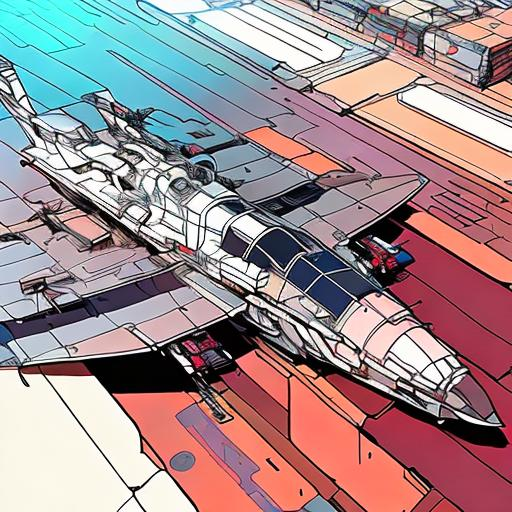

Images:  12%|█▎        | 1/8 [00:04<00:33,  4.84s/it]

### Old Map


- Macro shot of an old map, its yellowed paper, faded out text and old-style drawings are visible, surrounded by subtle wooden frame and an iron lock, nvinkpunk
  - *negative: modern map, digital map, world map, satellite map, hand-painted map, 3D model map, navigation map, cartoon map x dark colors, small size, blurry image, bad quality, sketch x*
    

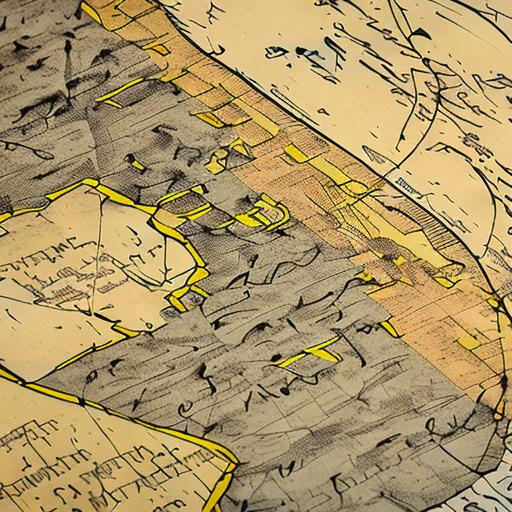

Images:  25%|██▌       | 2/8 [00:09<00:28,  4.68s/it]

### Navigation Wing


- Aerial shot of a large, red and angled spaceship with open docking bay, surrounded by stars and comets, nvinkpunk
  - *negative: People, clouds, animals, planets, buildings x futuristic, abstract, low-quality, sketch x bad quality, overlay, unsharpened, x*
    

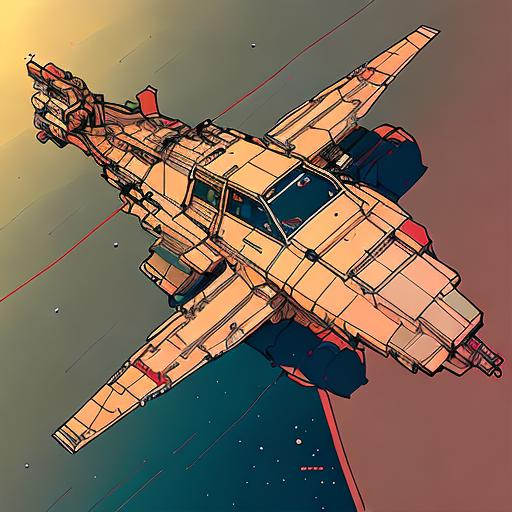

Images:  38%|███▊      | 3/8 [00:16<00:28,  5.76s/it]

### Mysterious Figure


- Closeup of mysterious figure, dressed in black robe, wearing a golden amulet and holding a mysterious staff, in the [docking bay] of spaceship, ebbing and flowing blue light, sci-fi, fantasy nvinkpunk
  - *negative: group of people, animals, animals wearing clothing, trees, bright sunlight, cartoonish x bad quality, sketch x*
    

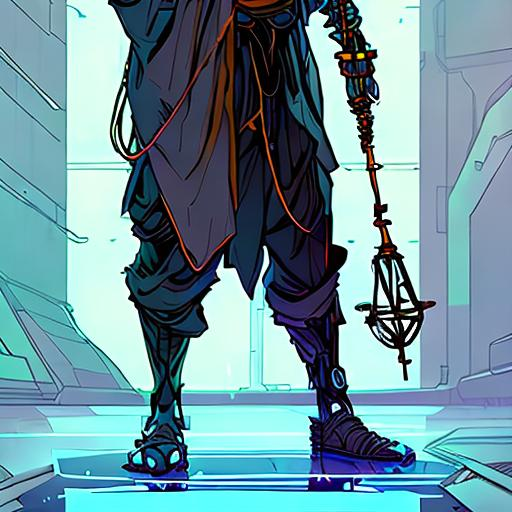

Images:  50%|█████     | 4/8 [00:21<00:21,  5.30s/it]

### Central Hub


- Aerial shot of large spaceship with red hull and sharp angles, its docking bay located in the front, all elements visible, mid-day light, science fiction, space travel, nvinkpunk
  - *negative: Car, train, aircraft, moon, water x cartoon, painting, sketch, low resolution, blurry, bad quality, nvinkpunk x*
    

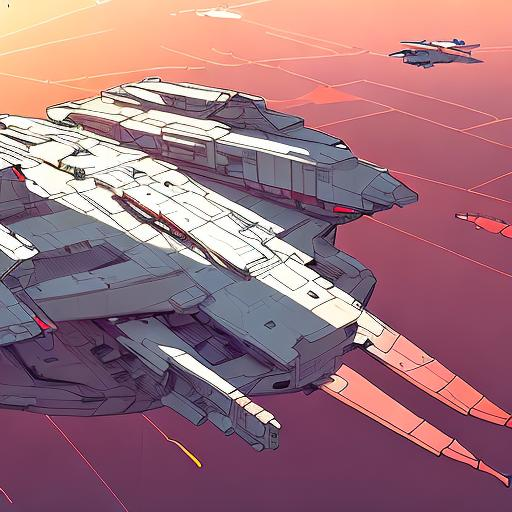

Images:  62%|██████▎   | 5/8 [00:25<00:15,  5.02s/it]

### Star Trek Inspired Spaceship


- Aerial shot of spaceship, with one central hub and five separate wings, red hull with sharp angles, five visible parts, docking bay, [standing in a sea of stars], in daylight, sci-fi, nvinkpunk
  - *negative: Vehicle, animal, portrait, landscape, still, abstract, x bad quality, sketch, over-exposure, blur, low-contrast, washed-out colors, x*
    

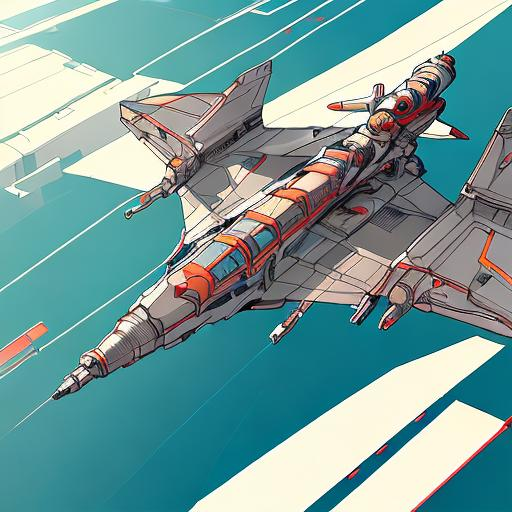

Images:  75%|███████▌  | 6/8 [00:30<00:09,  4.92s/it]

### Command Wing


- Aerial shot of large spaceship with red hull and sharp angles, docking bay located at the front, five wings and one central hub, modern sci-fi, nvinkpunk
  - *negative: No people, no interior elements, no weapons x no mountains, no clouds x bad quality, sketch, blur, nvinkpunk*
    

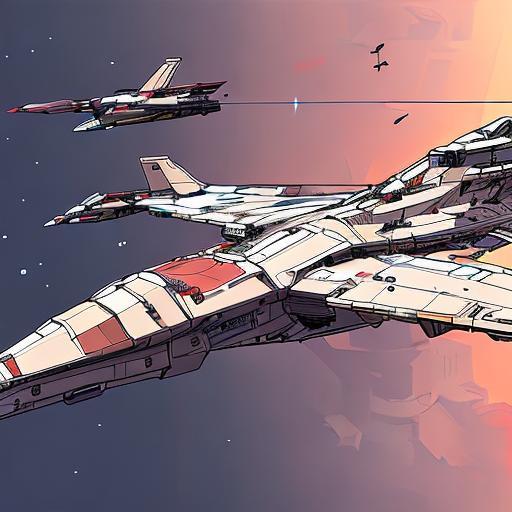

Images:  88%|████████▊ | 7/8 [00:34<00:04,  4.80s/it]

### Engineering Wing


- Aerial view of [engineering wing] of imposing, red spaceship, with sharp angles, and its docking bay in the front, in dark blue night, sci-fi, nvinkpunk
  - *negative: no people, no animals, x other ships, x natural environment, x generic structures, bad quality, sketch, x nvinkpunk*
    

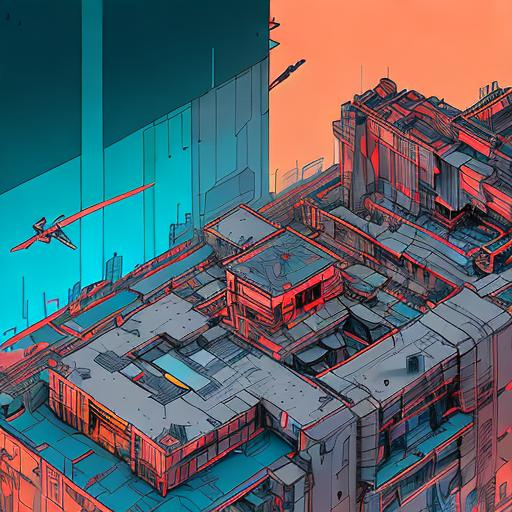

Images: 100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


8

In [4]:
from holodeck.gpt_image import generate_image
from IPython.display import display, Markdown
import PIL.Image as Image
import random


random.shuffle(img_prompts)

# img_prompts = img_prompts[:9]

images = []

for obj, gen_options in tqdm(img_prompts, desc="Images"):
    prompt = gen_options['prompt']
    negative_prompt = gen_options['negative_prompt']
    image_bytes = await generate_image(prompt=prompt, negative_prompt=negative_prompt)
    image = Image.open(image_bytes)
    display(Markdown(f"### {obj.name}"))
    display(Markdown(f"""
- {prompt}
  - *negative: {negative_prompt}*
    """))
    display(image)
    image_file_name = f".images/{obj.name}.png"
    image.save(image_file_name)
    image.close()
    image_bytes.close()
    del image_bytes
    images.append((obj, prompt, image_file_name))

len(images)


## Display Images

In [ ]:
import textwrap
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from PIL.Image import Resampling

text_width = 30
dpi = 600.0
fig_width = 3.234

columns = 4
pic_width = fig_width * 0.27


def plot_images(images):

    # Estimate the number of rows needed based on the number of images
    num_rows = (len(images) + columns - 1) // columns
    fig_height = 0
    # Get the height of the first image adjusted for scale
    with Image.open(images[0][2]) as img:
        w, h = img.size
        aspect_ratio = float(w) / h
        pic_height = pic_width / aspect_ratio

        fig_height = pic_height * num_rows * 1.6

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

    # Define the path effect for the outline
    outline_effect = withStroke(linewidth=0.3, foreground='black')

    # Loop over the images and create a subplot for each
    for i, (obj, prompt, image_file_name) in enumerate(images):
        with Image.open(image_file_name) as image:
        
            # Resize the image
            w, h = image.size
            aspect_ratio = float(w) / h
            new_width = int(pic_width * dpi)
            new_height = int(new_width / aspect_ratio)
            with image.resize((new_width, new_height), Resampling.LANCZOS) as image_resized:
                # Create a subplot for the image
                ax = fig.add_subplot(len(images) // columns + 1, columns, i + 1)
                
                # Display the image
                ax.imshow(image_resized)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal') # set aspect ratio to 1:1
        
        # Set the title to the obj.name
        # ax.set_title(obj.name, fontsize=4, color='magenta', pad=-10)
        
        # Wrap the prompt text to the desired width
        wrapped_prompt = textwrap.fill(prompt, width=text_width)
        wrapped_title = textwrap.fill(obj.name, width=14)
        
        # Display the wrapped prompt text below the title with black outline
        ax.text(0.08, -0.38, wrapped_prompt, ha='left', va='bottom', transform=ax.transAxes, fontsize=1.7, family='monospace', color='white', path_effects=[outline_effect])
        
        ax.text(1.0-0.08, -0.4, wrapped_title, ha='right', va='top', transform=ax.transAxes, fontsize=2.4, family='monospace', color='magenta', path_effects=[outline_effect])

    plt.subplots_adjust(wspace=0.03)

    fig.patch.set_facecolor('none')


plot_images(images)
